<a href="https://colab.research.google.com/github/project-ida/arpa-e-experiments/blob/main/analysis/nassisi-03/Nassisi_3_Refined_PSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Nassisi 3
We have noticed that due to the long duration of the Nassisi experiment, there is some detector drift, causing the neutron and gamma bands to shift over time. In order to get a more accurate count of neutrons, we will break the experiment into chunks and analyze each separately.

Nassisi 3 ran from 16:25 April 4 to 12:00 June 20.

In [ ]:
# Auth
import sys, os
import shutil
from google.colab import drive
from google.colab import auth

# Data analysis
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from sqlalchemy import create_engine, text

# Plotting
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.graph_objects as go

In [ ]:
# Mount Drive
drive.mount('/content/drive')

# Copy SQL credentials from Google drive
shutil.copy("/content/drive/MyDrive/Nucleonics/.env/psql_credentials_readonly.py", "psql_credentials.py")

Mounted at /content/drive


'psql_credentials.py'

In [ ]:
# Import SQL credentials
from psql_credentials import PGUSER, PGPASSWORD, PGHOST, PGPORT, PGDATABASE

# Create the database connection string
connection_uri = f'postgresql+psycopg2://{PGUSER}:{PGPASSWORD}@{PGHOST}:{PGPORT}/{PGDATABASE}'
engine = create_engine(connection_uri)

In [ ]:
def get_psd_data(start_time, end_time, digitizer, channel_number):
  query = f"""
  SELECT
      width_bucket(channels[1], 0, 1, 128) AS psp_bin,
      width_bucket(channels[2], 0, 4000, 512) AS energy_bin,
      COUNT(*) AS count
  FROM {digitizer}_ch{channel_number}
  WHERE time BETWEEN '{start_time}' AND '{end_time}'
  GROUP BY psp_bin, energy_bin
  ORDER BY psp_bin, energy_bin;
  """
  return pd.read_sql(query, engine, index_col=None)


In [ ]:
def get_event_data(start_time, end_time, psp=">0", energy=">0"):
  query = f"""
  SELECT * FROM {digitizer}_ch{channel_number}
  WHERE channels[1] {psp} AND channels[2] {energy}
  AND time BETWEEN '{start_time}' AND '{end_time}'
  ORDER BY time;
  """
  df = pd.read_sql(query, engine, index_col=None)
  df.set_index('time', inplace=True)
  return df

In [ ]:
def reconstruct_ns_pulses(df):
  # Floor the index to strip microseconds
  df.index = df.index.floor('s')

  # Convert picoseconds to nanoseconds
  df['ps_ns'] = df['ps'] // 1_000  # convert ps → ns

  # Create high-resolution timestamp
  df['timestamp'] = df.index + pd.to_timedelta(df['ps_ns'], unit='ns')

  # Set timestamp as index
  df.set_index('timestamp', inplace=True)

  # Create 'counts' column with value 1 for each row
  df['counts'] = 1

  # Drop all unneeded columns (including 'channels')
  df.drop(columns=['id', 'ps', 'ps_ns', 'channels'], inplace=True)

  # Sort by timestamp index
  df.sort_index(inplace=True)

  return df

In [ ]:
# --- Gaussian definitions ---
def gaussian(x, amp, mu, sigma):
    return amp * np.exp(-(x - mu)**2 / (2 * sigma**2))

def double_gaussian(x, amp1, mu1, sigma1, amp2, mu2, sigma2):
    return (gaussian(x, amp1, mu1, sigma1) +
            gaussian(x, amp2, mu2, sigma2))

def find_psp_threshold_gaussian(data, target_energy=500,
                                     energy_range=(0, 4000), psp_range=(0, 1),
                                     energy_bins=512, psp_bins=128,
                                     plot=True, mean_tol=0.05, amp_ratio_tol=0.1,
                                     num_sigma=4):
    """
    Fits Gaussian(s) to PSP distribution at a given energy and finds PSP threshold
    where the lower psp Gaussian drops to level give by num_sigma*sigma
    Falls back to single Gaussian if fitted Gaussians are too similar.
    """

    # Step 1: Map energy to closest bin
    bin_width_e = (energy_range[1] - energy_range[0]) / energy_bins
    closest_energy_bin = int(round(target_energy / bin_width_e))
    closest_energy_bin = max(1, min(closest_energy_bin, energy_bins))

    # Step 2: Filter data for that energy bin
    filtered = data[data['energy_bin'] == closest_energy_bin]
    if filtered.empty:
        raise ValueError(f"No data for bin {closest_energy_bin} (~{target_energy})")

    # Step 3: Build histogram
    psp_bin_width = (psp_range[1] - psp_range[0]) / psp_bins
    hist = np.zeros(psp_bins)
    for _, row in filtered.iterrows():
        idx = row['psp_bin'] - 1
        if 0 <= idx < psp_bins:
            hist[idx] += row['count']

    psp_centres = np.arange(psp_bins) * psp_bin_width + psp_bin_width / 2

    # Step 4: Try to detect peaks
    peaks, _ = find_peaks(hist, height=np.max(hist) * 0.05)
    use_double = len(peaks) >= 2

    if use_double:
        # Initial guess: amplitudes, means, sigmas
        p0 = [hist[peaks[0]], psp_centres[peaks[0]], 0.01,
              hist[peaks[1]], psp_centres[peaks[1]], 0.01]
        bounds = (0, [np.inf, 1, np.inf, np.inf, 1, np.inf])
        popt, _ = curve_fit(double_gaussian, psp_centres, hist, p0=p0, bounds=bounds)
        params = [(popt[0], popt[1], popt[2]), (popt[3], popt[4], popt[5])]

        # Check if we should fall back to single Gaussian
        mu_diff = abs(params[0][1] - params[1][1])
        amp_ratio = min(params[0][0], params[1][0]) / max(params[0][0], params[1][0])
        if mu_diff < mean_tol or amp_ratio < amp_ratio_tol:
            use_double = False

    if not use_double:
        # Fit single Gaussian
        p0 = [np.max(hist), psp_centres[np.argmax(hist)], 0.01]
        bounds = (0, [np.inf, 1, np.inf])
        popt, _ = curve_fit(gaussian, psp_centres, hist, p0=p0, bounds=bounds)
        params = [tuple(popt)]

    # Step 5: Select lower Gaussian (smallest mean)
    lower_gauss = min(params, key=lambda p: p[1])
    amp, mu, sigma = lower_gauss

    # Step 6: Compute PSP threshold at num_sigma*sigma
    psp_threshold = mu + num_sigma*sigma  # right-side cutoff

    # Step 7: Plot
    if plot:
        plt.figure(figsize=(8, 5))
        plt.bar(psp_centres, hist, width=psp_bin_width, alpha=0.6, label="Data")
        if use_double:
            plt.plot(psp_centres, double_gaussian(psp_centres, *popt), 'k-', label="Double Gaussian fit")
            for amp_i, mu_i, sigma_i in params:
                plt.plot(psp_centres, gaussian(psp_centres, amp_i, mu_i, sigma_i), '--', label=f"Gaussian μ={mu_i:.3f}")
        else:
            plt.plot(psp_centres, gaussian(psp_centres, *params[0]), 'k-', label="Single Gaussian fit")
        plt.axvline(psp_threshold, color='r', linestyle='--', label=f"Threshold={psp_threshold:.3f}")
        plt.xlabel('PSP')
        plt.ylabel('Count')
        plt.title(f'PSP Gaussian Fit at Energy ~{target_energy}')
        plt.legend()
        plt.show()

    return psp_threshold

In [ ]:
digitizer = "caen8ch"
channel_number = 3

In [ ]:
#Break range into 2 day periods

from datetime import datetime, timedelta

start_time_str = '2025-04-04 16:25'
end_time_str = '2025-06-20 12:00'

start_time = datetime.strptime(start_time_str, '%Y-%m-%d %H:%M')
end_time = datetime.strptime(end_time_str, '%Y-%m-%d %H:%M')

time_periods = []
all_times = []
current_start_time = start_time

while current_start_time < end_time:
    current_end_time = current_start_time + timedelta(days=2)
    if current_end_time > end_time:
        current_end_time = end_time
    time_periods.append((current_start_time.strftime('%Y-%m-%d %H:%M'), current_end_time.strftime('%Y-%m-%d %H:%M')))
    all_times.append((current_start_time.strftime('%Y-%m-%d %H:%M'), current_end_time.strftime('%Y-%m-%d %H:%M')))
    current_start_time = current_end_time

for start, end in time_periods:
    print(f"Start: {start}, End: {end}")

Start: 2025-04-04 16:25, End: 2025-04-06 16:25
Start: 2025-04-06 16:25, End: 2025-04-08 16:25
Start: 2025-04-08 16:25, End: 2025-04-10 16:25
Start: 2025-04-10 16:25, End: 2025-04-12 16:25
Start: 2025-04-12 16:25, End: 2025-04-14 16:25
Start: 2025-04-14 16:25, End: 2025-04-16 16:25
Start: 2025-04-16 16:25, End: 2025-04-18 16:25
Start: 2025-04-18 16:25, End: 2025-04-20 16:25
Start: 2025-04-20 16:25, End: 2025-04-22 16:25
Start: 2025-04-22 16:25, End: 2025-04-24 16:25
Start: 2025-04-24 16:25, End: 2025-04-26 16:25
Start: 2025-04-26 16:25, End: 2025-04-28 16:25
Start: 2025-04-28 16:25, End: 2025-04-30 16:25
Start: 2025-04-30 16:25, End: 2025-05-02 16:25
Start: 2025-05-02 16:25, End: 2025-05-04 16:25
Start: 2025-05-04 16:25, End: 2025-05-06 16:25
Start: 2025-05-06 16:25, End: 2025-05-08 16:25
Start: 2025-05-08 16:25, End: 2025-05-10 16:25
Start: 2025-05-10 16:25, End: 2025-05-12 16:25
Start: 2025-05-12 16:25, End: 2025-05-14 16:25
Start: 2025-05-14 16:25, End: 2025-05-16 16:25
Start: 2025-0

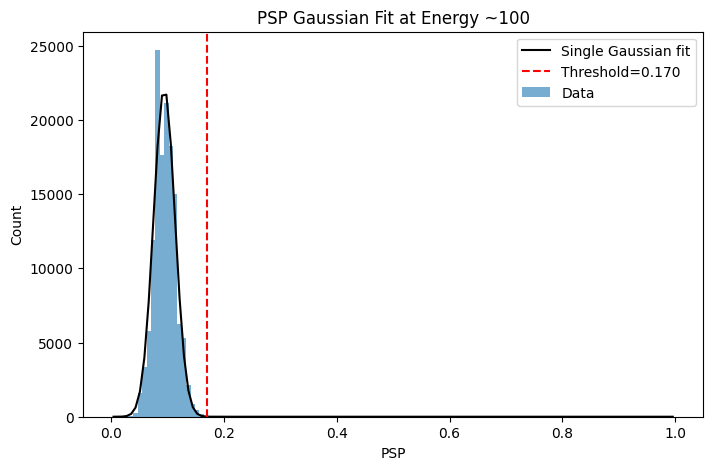

0.10575209314027159


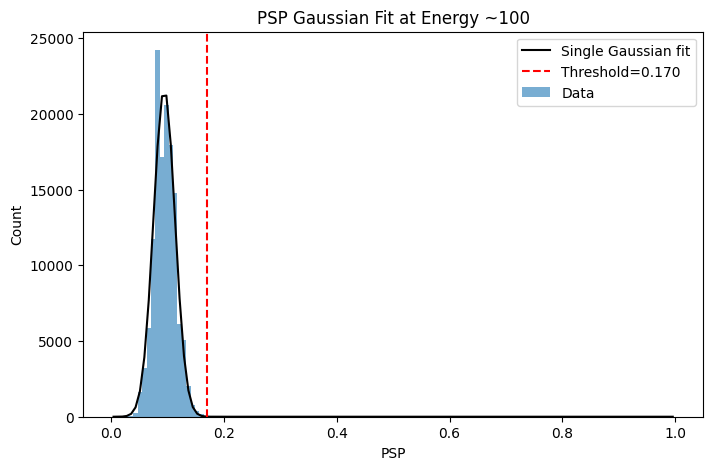

0.044783754088545354


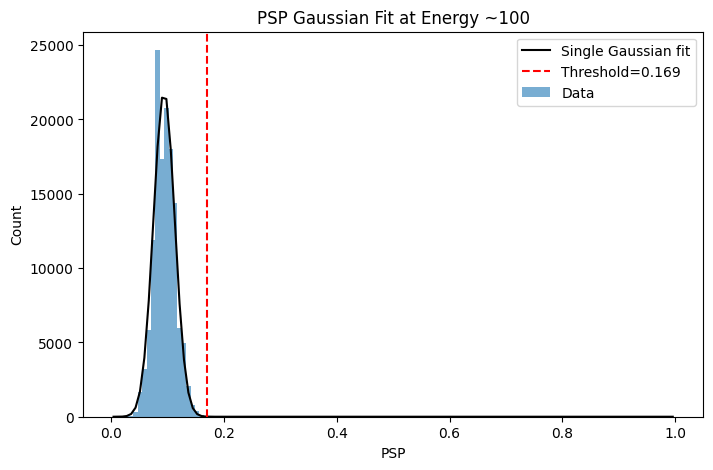

0.0492203198108524


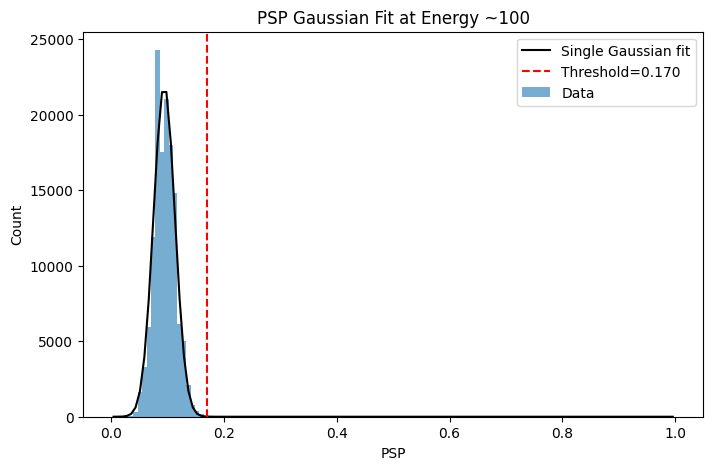

0.04723592700030425


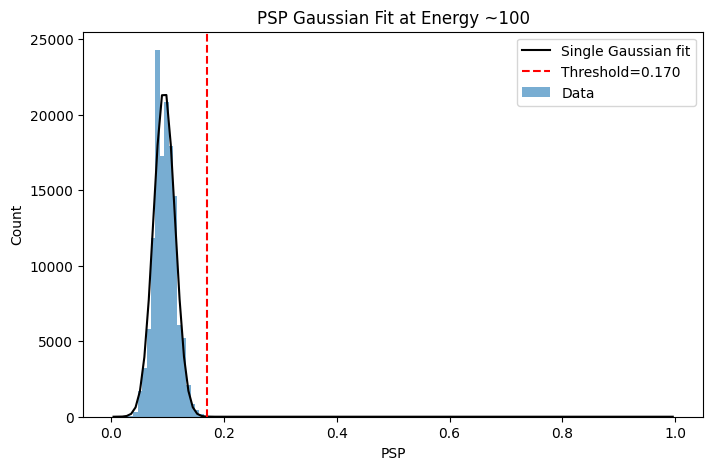

0.04630034097449322


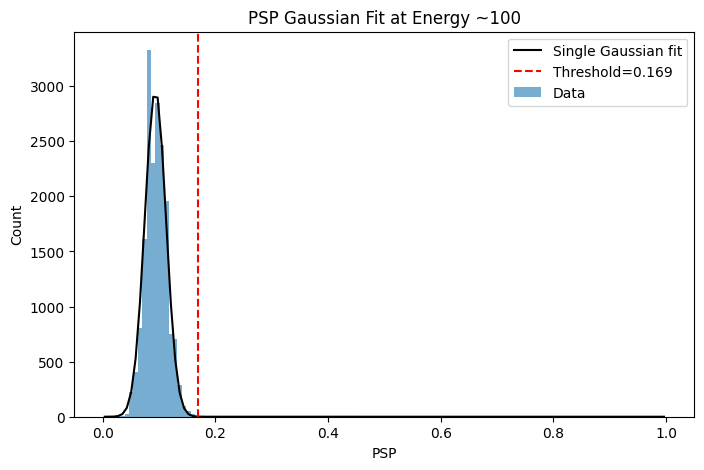

0.050772062663323965


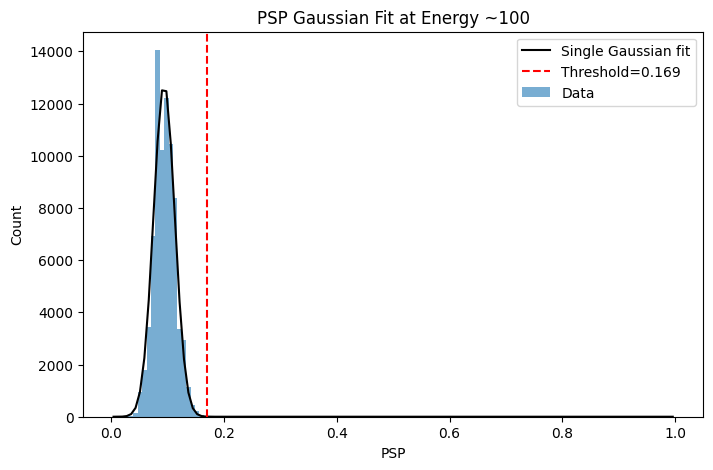

0.04960866048283639


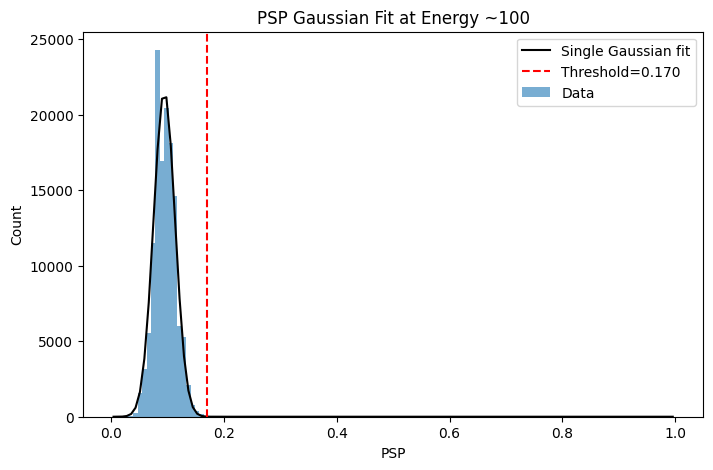

0.04590482739731298


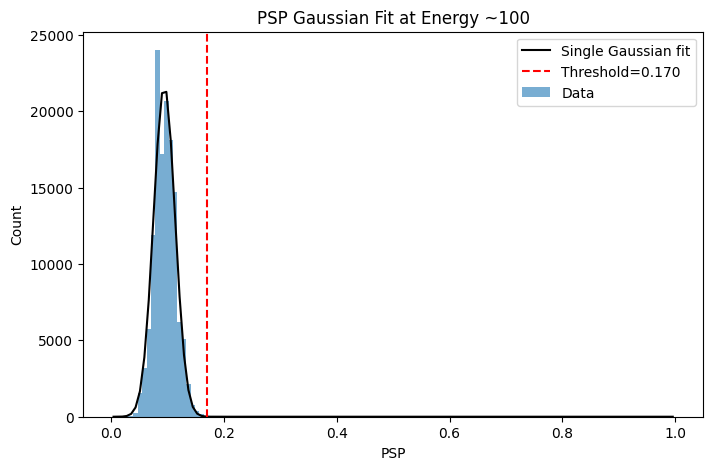

0.042580757958852564


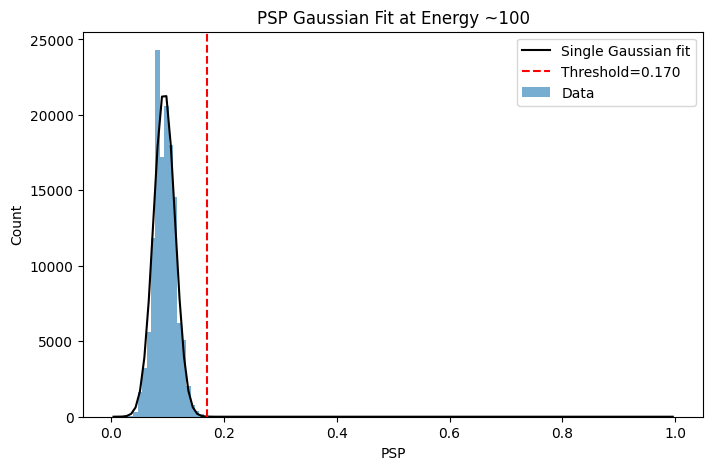

0.044831290034797196


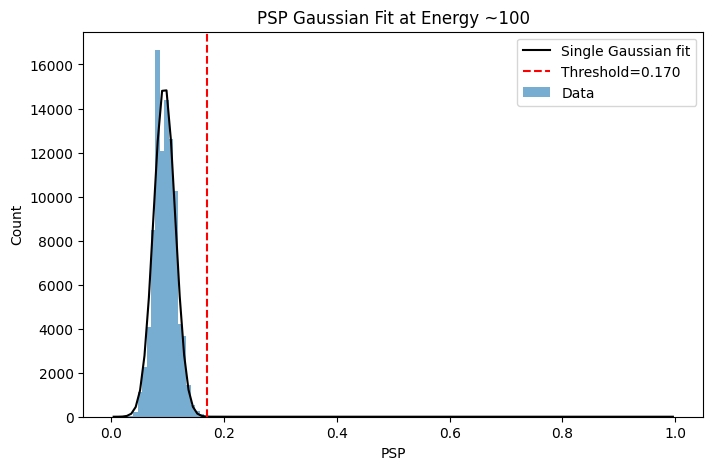

0.041637956546472454


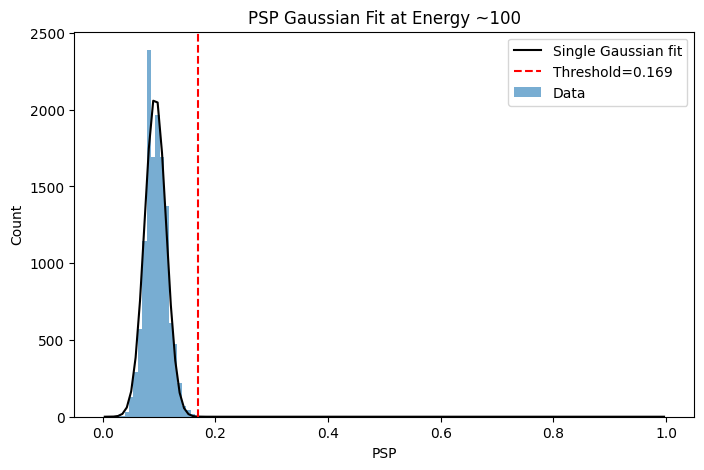

0.05019871466680207


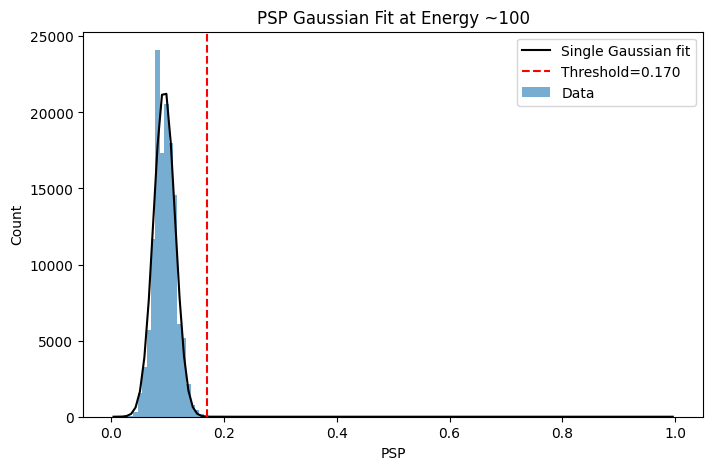

0.04559600541337558


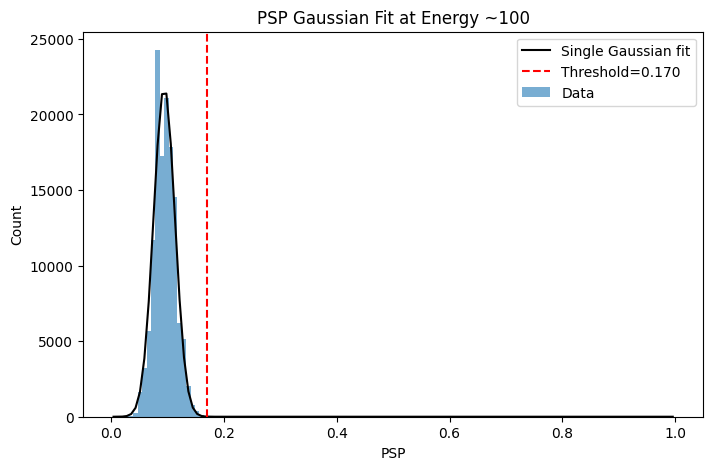

0.04739769396163647


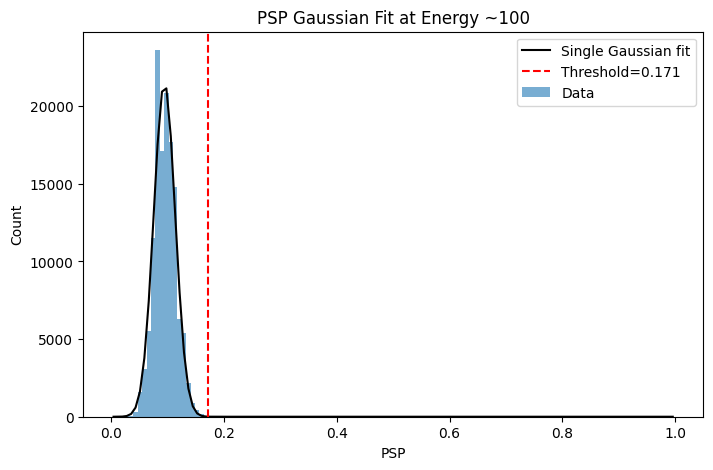

0.044419552115070975


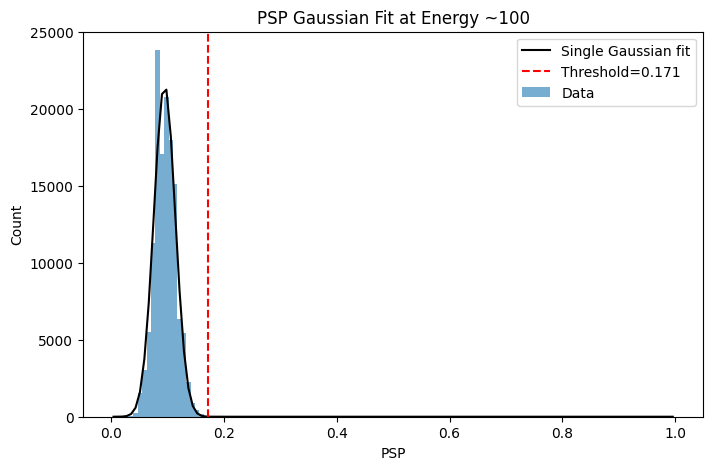

0.04395624768306522


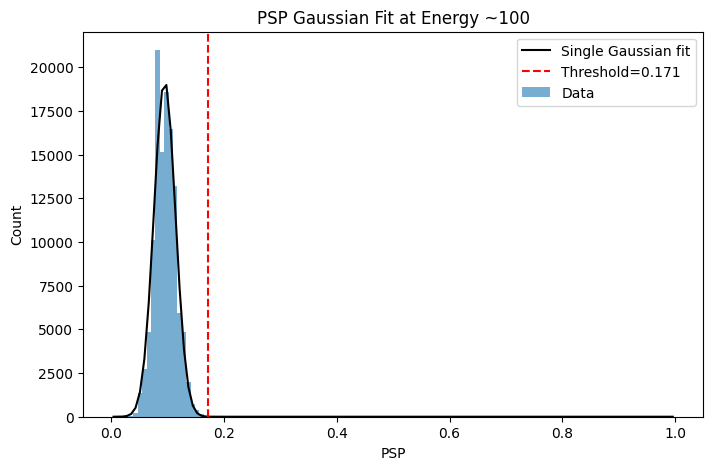

0.03860873520053027


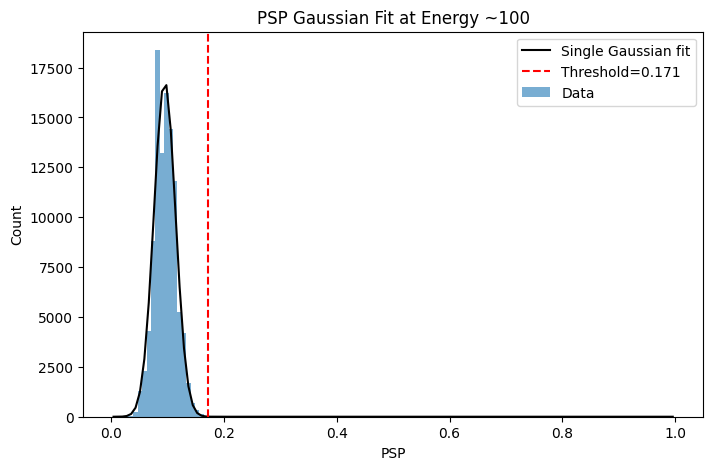

0.034175261901264534


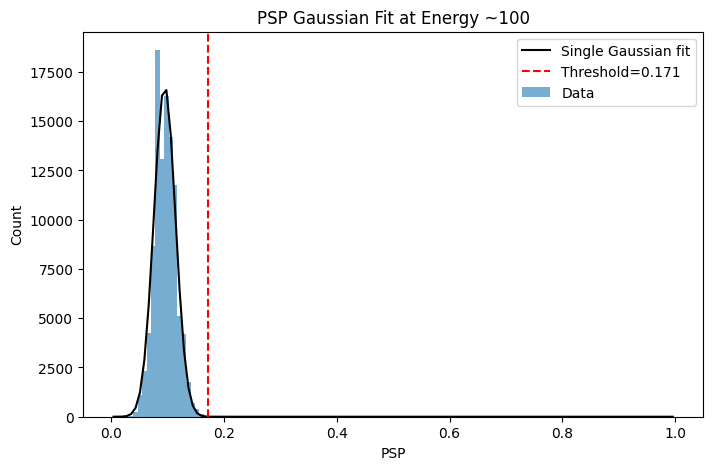

0.033746243218018224


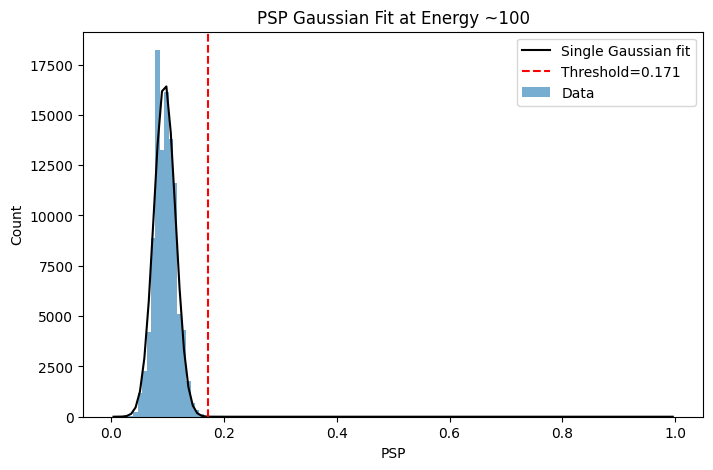

0.03314127006975623


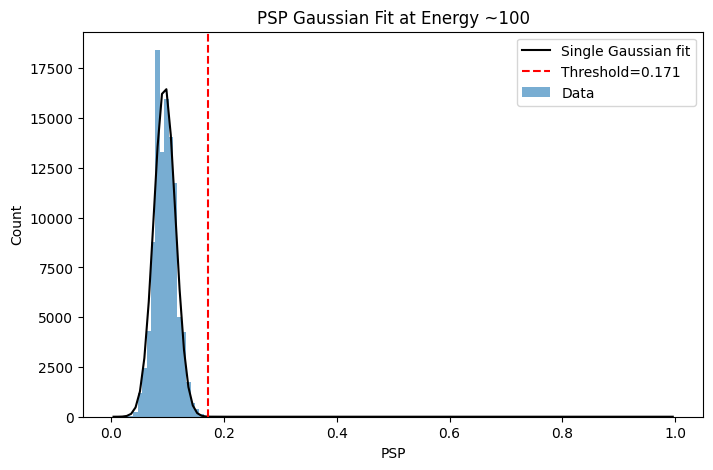

0.034787861183274045


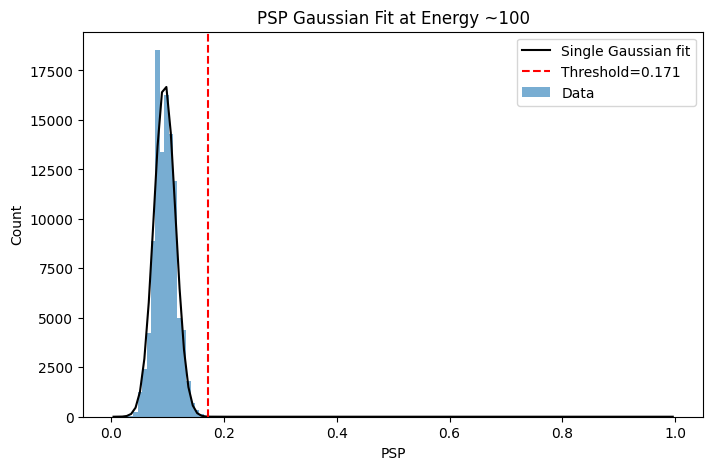

0.036553413492488


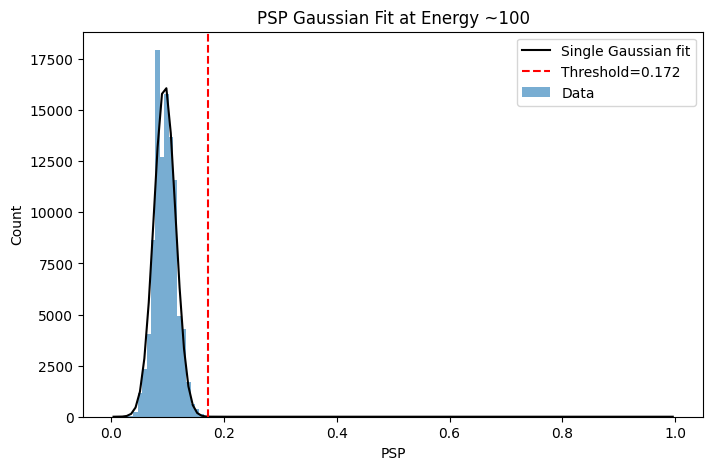

0.035757609256153636


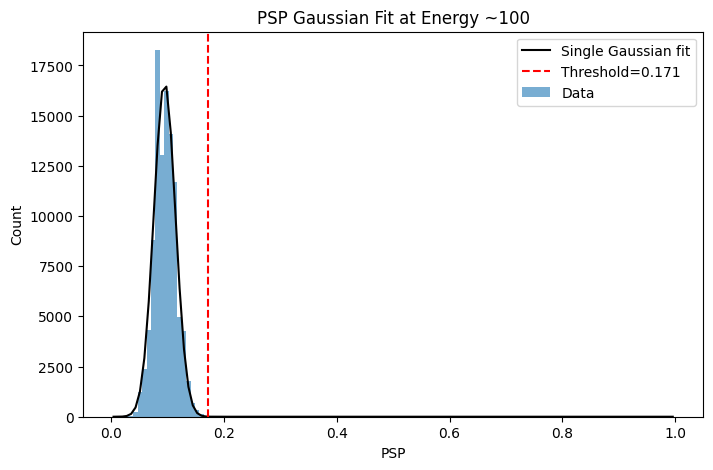

0.035306534240241806


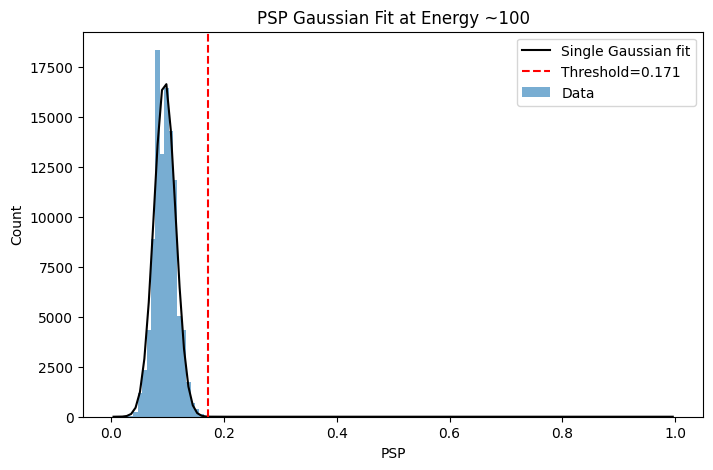

0.03671140342810095


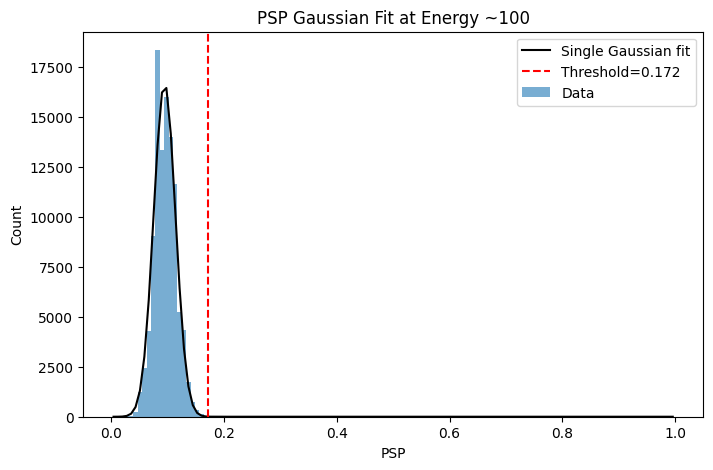

0.035457414441532234


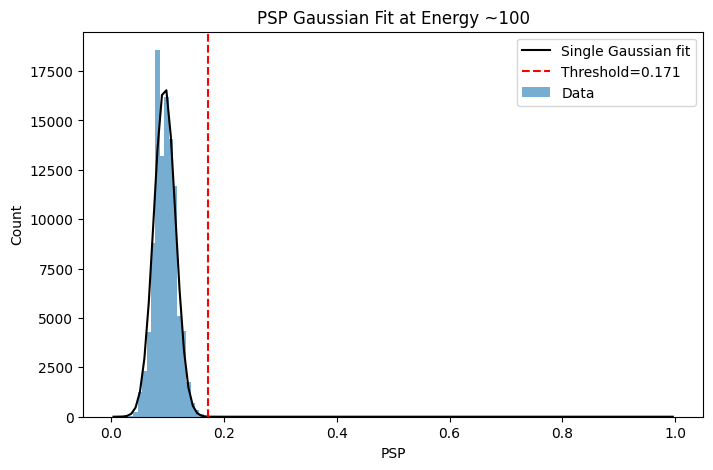

0.03472735416370335


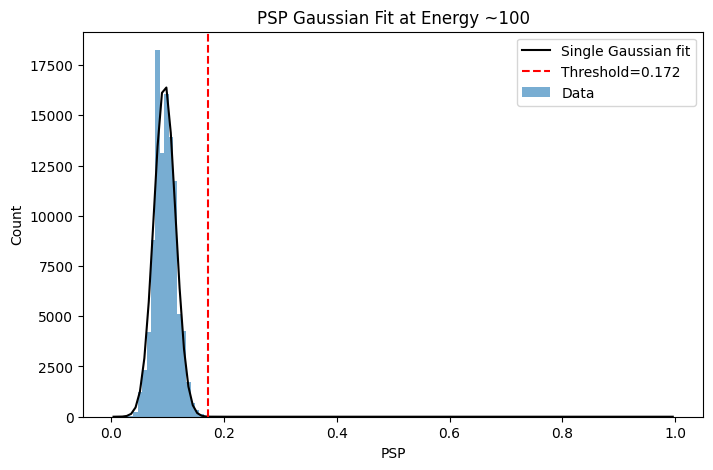

0.035871429275777154


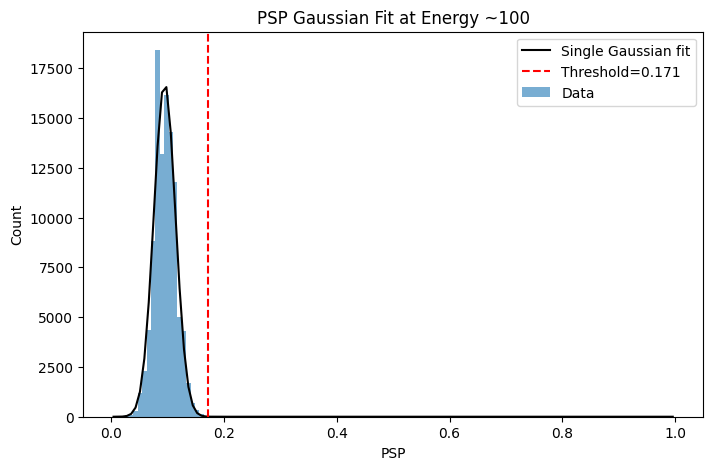

0.03625603029667042


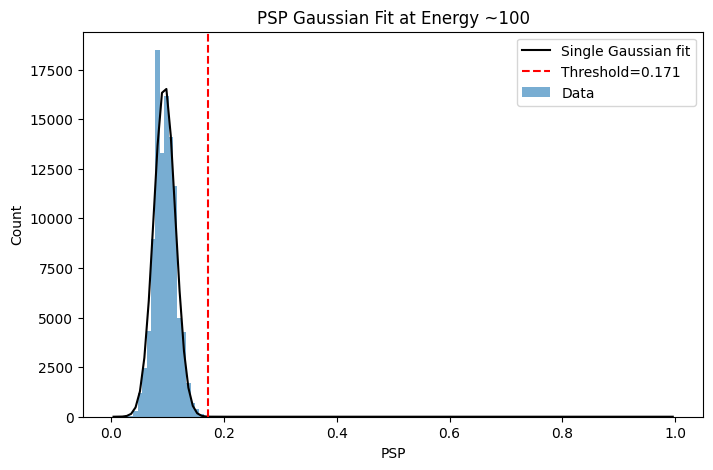

0.0346739573644683


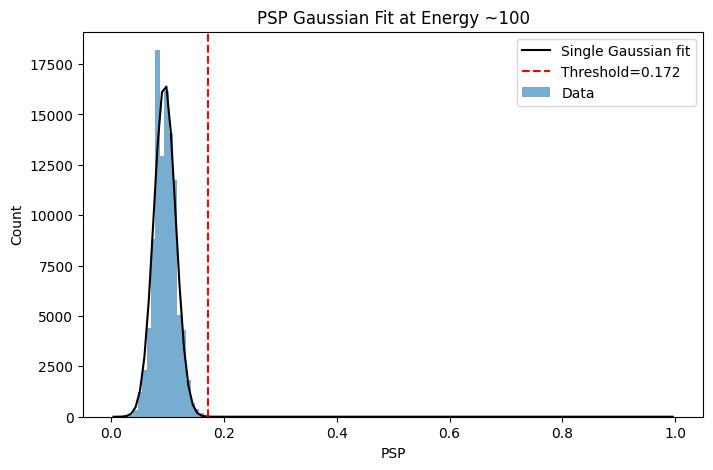

0.03439787253413247


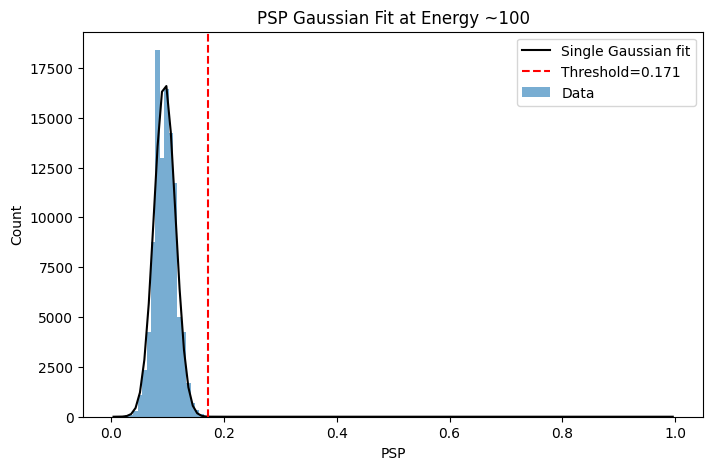

0.03508333559957128


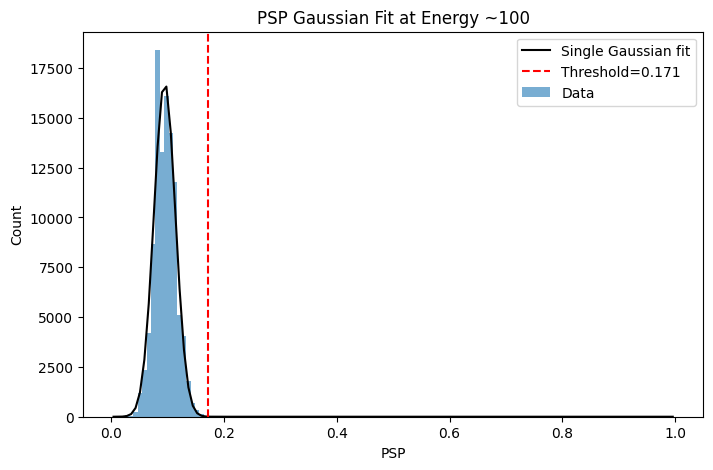

0.03349667433048724


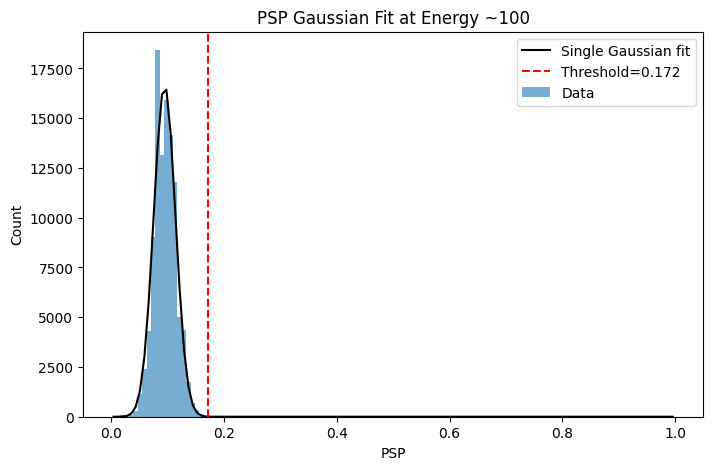

0.033375350416737844


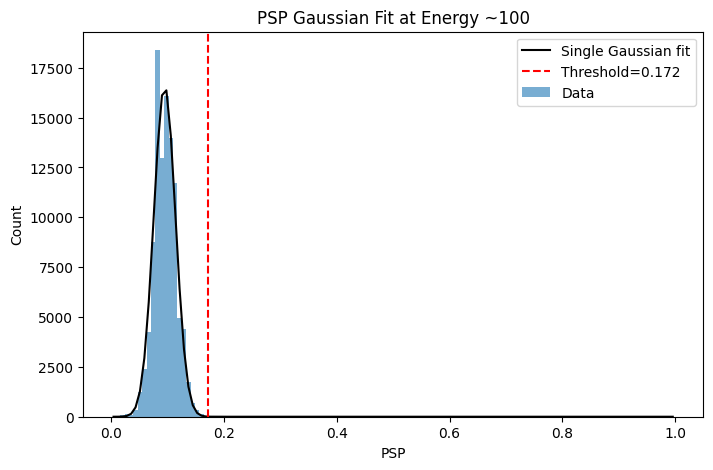

0.03274598251244439


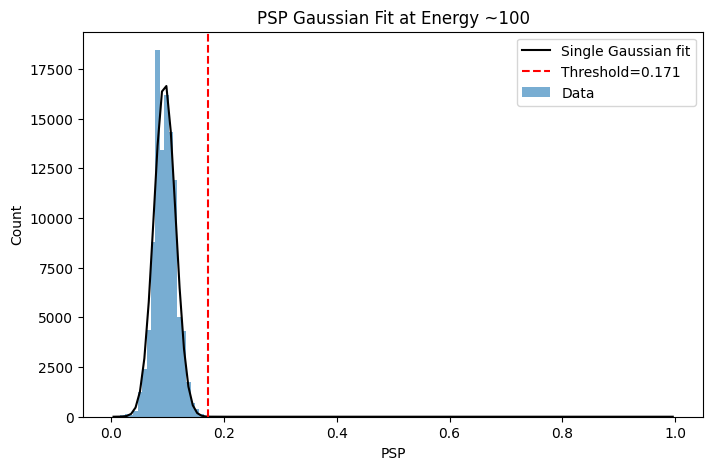

0.03306775745261814


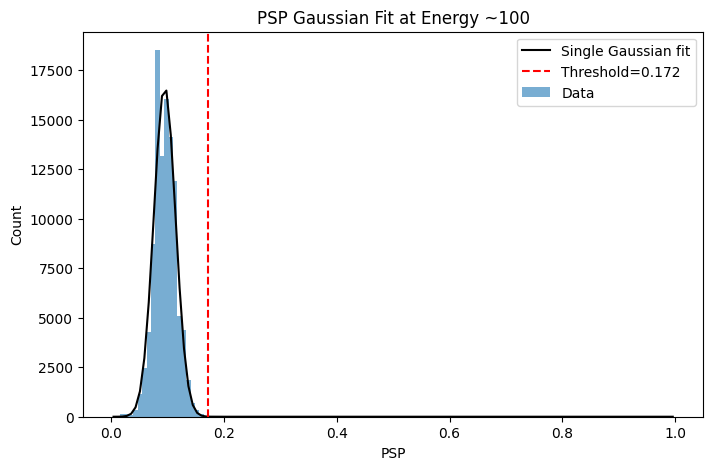

0.03214441336689705


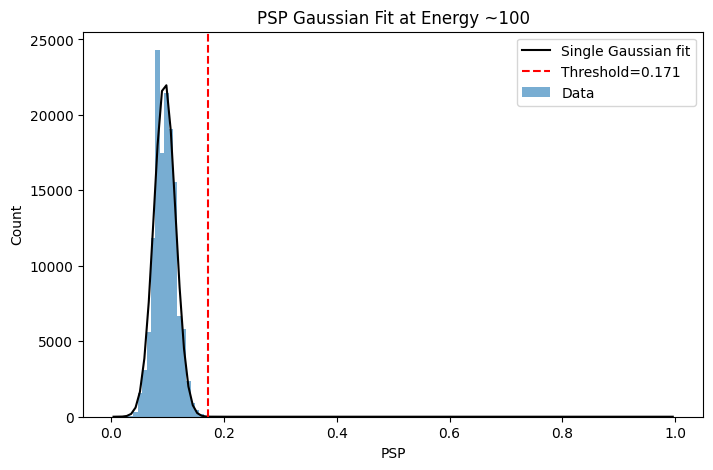

0.0427922473220266


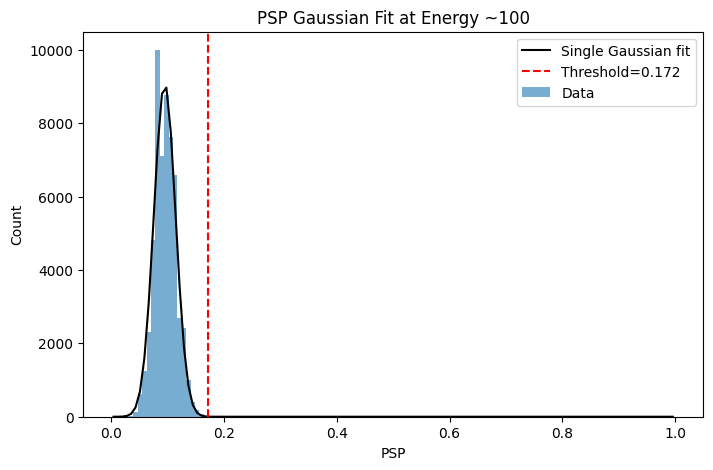

0.04262291503538231


In [ ]:
#For each start and end time in start and end, run get_psd_data and return a list of the PSPs
psd_list = []
neutron_rates = []
for start, end in time_periods:
    df_psd = get_psd_data(start, end, digitizer, channel_number)
    psp_threshold = find_psp_threshold_gaussian(df_psd, target_energy=100, num_sigma=4)
    psd_list.append(psp_threshold)
    neutron_data = get_event_data(start,end,f">{psp_threshold}")#,">500")
    neutron_data = reconstruct_ns_pulses(neutron_data)
    deltas = np.diff(neutron_data.index.values).astype("timedelta64[ns]") / np.timedelta64(1, "s")
    delta_sorted = np.sort(deltas)
    lam = 1 / np.mean(delta_sorted)
    print(lam)
    neutron_rates.append(lam)



In [ ]:
psd_list

[np.float64(0.17004438991164184),
 np.float64(0.17019396973835715),
 np.float64(0.16923172548003346),
 np.float64(0.16977500590766392),
 np.float64(0.1699777913475326),
 np.float64(0.1691045938644187),
 np.float64(0.16886753734087595),
 np.float64(0.1701331232927718),
 np.float64(0.17022305039367655),
 np.float64(0.1699992112983229),
 np.float64(0.1703075302278454),
 np.float64(0.16934130045042112),
 np.float64(0.17007909896832465),
 np.float64(0.16954041839928052),
 np.float64(0.1706706887719819),
 np.float64(0.17092716466603658),
 np.float64(0.171122282110736),
 np.float64(0.17149528759832877),
 np.float64(0.17115112482412403),
 np.float64(0.1712698973245188),
 np.float64(0.1714381441602858),
 np.float64(0.17125988309497947),
 np.float64(0.1716744480081614),
 np.float64(0.1714084312814692),
 np.float64(0.17132529915503045),
 np.float64(0.17175261722103302),
 np.float64(0.17125874847473826),
 np.float64(0.17155762576051029),
 np.float64(0.17138264831312783),
 np.float64(0.171089648520

In [ ]:
neutron_rates

[np.float64(0.10575209314027159),
 np.float64(0.044783754088545354),
 np.float64(0.0492203198108524),
 np.float64(0.04723592700030425),
 np.float64(0.04630034097449322),
 np.float64(0.050772062663323965),
 np.float64(0.04960866048283639),
 np.float64(0.04590482739731298),
 np.float64(0.042580757958852564),
 np.float64(0.044831290034797196),
 np.float64(0.041637956546472454),
 np.float64(0.05019871466680207),
 np.float64(0.04559600541337558),
 np.float64(0.04739769396163647),
 np.float64(0.044419552115070975),
 np.float64(0.04395624768306522),
 np.float64(0.03860873520053027),
 np.float64(0.034175261901264534),
 np.float64(0.033746243218018224),
 np.float64(0.03314127006975623),
 np.float64(0.034787861183274045),
 np.float64(0.036553413492488),
 np.float64(0.035757609256153636),
 np.float64(0.035306534240241806),
 np.float64(0.03671140342810095),
 np.float64(0.035457414441532234),
 np.float64(0.03472735416370335),
 np.float64(0.035871429275777154),
 np.float64(0.03625603029667042),
 np.

In [ ]:
#Calculate the average of neutron_rates
average_neutron_rate = np.mean(neutron_rates)
average_neutron_rate

np.float64(0.04142813512923818)

In [ ]:
all_times

[('2025-04-04 16:25', '2025-04-06 16:25'),
 ('2025-04-06 16:25', '2025-04-08 16:25'),
 ('2025-04-08 16:25', '2025-04-10 16:25'),
 ('2025-04-10 16:25', '2025-04-12 16:25'),
 ('2025-04-12 16:25', '2025-04-14 16:25'),
 ('2025-04-14 16:25', '2025-04-16 16:25'),
 ('2025-04-16 16:25', '2025-04-18 16:25'),
 ('2025-04-18 16:25', '2025-04-20 16:25'),
 ('2025-04-20 16:25', '2025-04-22 16:25'),
 ('2025-04-22 16:25', '2025-04-24 16:25'),
 ('2025-04-24 16:25', '2025-04-26 16:25'),
 ('2025-04-26 16:25', '2025-04-28 16:25'),
 ('2025-04-28 16:25', '2025-04-30 16:25'),
 ('2025-04-30 16:25', '2025-05-02 16:25'),
 ('2025-05-02 16:25', '2025-05-04 16:25'),
 ('2025-05-04 16:25', '2025-05-06 16:25'),
 ('2025-05-06 16:25', '2025-05-08 16:25'),
 ('2025-05-08 16:25', '2025-05-10 16:25'),
 ('2025-05-10 16:25', '2025-05-12 16:25'),
 ('2025-05-12 16:25', '2025-05-14 16:25'),
 ('2025-05-14 16:25', '2025-05-16 16:25'),
 ('2025-05-16 16:25', '2025-05-18 16:25'),
 ('2025-05-18 16:25', '2025-05-20 16:25'),
 ('2025-05-

In [ ]:
#Plot neutron_rates over time using pltly
#Convert all_times to timestamps
start_times = [period[0] for period in all_times]

fig = go.Figure(layout=dict(yaxis_title="Neutrons per second", showlegend=False, height=600, width=800))
fig.add_trace(go.Scattergl(name="Neutrons per second", x=start_times, y=neutron_rates))



In [ ]:
fig = go.Figure(layout=dict(yaxis_title="PSP", showlegend=False, height=600, width=800))
fig.add_trace(go.Scattergl(name="PSP", x=start_times, y=psd_list))

#Conclusion

The drift in the PSP distribution mostly occured in a discrete event, namely, when the chamber was transferred to the LASER lab for laser treatment. This may have been caused by small disturbances in the electrical connections. Overall, the drift is found to be small, so for the analysis we will use the average PSP cutoff for discrimination.